# Imports

In [21]:
import pandas as pd
import numpy as np

# import tensorflow as tf
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

In [22]:
file_path = 'Data/preprocessed_exoplanet_data.csv'  

df = pd.read_csv(file_path, comment='#')

print("Header:", df.columns.tolist())
print("First 5 rows of data:", df.head())

Header: ['koi_period', 'koi_time0bk', 'koi_impact', 'koi_duration', 'koi_depth', 'koi_prad', 'koi_teq', 'koi_insol', 'koi_model_snr', 'koi_steff', 'koi_slogg', 'koi_srad', 'ra', 'dec', 'koi_kepmag', 'label']
First 5 rows of data:    koi_period  koi_time0bk  koi_impact  koi_duration  koi_depth  koi_prad  \
0    9.488036   170.538750       0.146       2.95750      615.8      2.26   
1   54.418383   162.513840       0.586       4.50700      874.8      2.83   
2    1.736952   170.307565       1.276       2.40641     8079.2     33.46   
3    2.525592   171.595550       0.701       1.65450      603.3      2.75   
4   11.094321   171.201160       0.538       4.59450     1517.5      3.90   

   koi_teq  koi_insol  koi_model_snr  koi_steff  koi_slogg  koi_srad  \
0    793.0      93.59           35.8     5455.0      4.467     0.927   
1    443.0       9.11           25.8     5455.0      4.467     0.927   
2   1395.0     891.96          505.6     5805.0      4.564     0.791   
3   1406.0     926.

# Preprocessing

"Moreover, feature scaling, an important preprocessing technique in machine learning, is applied to the dataset.
It transforms numerical features to a common scale to prevent those with larger ranges from disproportionately
influencing the model’s performance. The stellar flux values in the dataset are normalized around zero and long-
term variations, such as those resulting from stellar activity or instrumental effects, are removed from the light
curves. This is a standard step in time-series analysis for exoplanet detection, as it eliminates baseline trends and
enhances the visibility of short-term variations like transits." - https://arxiv.org/abs/2508.09689


In [23]:
'''Train-Test/Normalization'''

X = df.iloc[:, :-1] # Feature columns
y = df.iloc[:, -1] # Target column

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Look into Stellar Flux Values for normalization and maybe remove some values that would hinder the model

# Look into Feature Importance!!

# Model Training

In [24]:
# Instantiate model
boost = XGBClassifier(
    n_estimators=100,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
#Fitting model to the train set
boost.fit(X_train_scaled_df, y_train)

c:\Users\tej11\uvic\NASAHackathon\NASA_Hackathon2025\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:31:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


# Evalutation and Metrics

In [25]:
# Imports
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix
)
import matplotlib.pyplot as plt

In [26]:
# Evaluation Function
def evaluate_binary_classification(model, X_test, y_test, plot_roc=True):
    """
    Evaluate a binary classification model with the following metrics:
        - accuracy
        - precision
        - recall
        - f1
        - roc_auc
        - confusion matrix
    """

    y_pred = model.predict(X_test)

    # Probabiliites for ROC AUC
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]  # probability of positive class
    elif hasattr(model, "decision_function"):
        y_prob = model.decision_function(X_test)
    else:
        y_prob = None

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None
    cm = confusion_matrix(y_test, y_pred)

    # Print Metrics
    print("Confusion Matrix:")
    print(cm)
    print("\nAccuracy: {:.4f}".format(acc))
    print("Precision: {:.4f}".format(prec))
    print("Recall: {:.4f}".format(rec))
    print("F1 Score: {:.4f}".format(f1))
    if roc_auc is not None:
        print("ROC AUC: {:.4f}".format(roc_auc))

    # Plot ROC Curve
    if plot_roc and y_prob is not None:
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        plt.figure(figsize=(6,6))
        plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
        plt.plot([0,1], [0,1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.show()

    # Return metrics as dict
    metrics_dict = {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1,
        "roc_auc": roc_auc,
        "confusion_matrix": cm
    }

    return metrics_dict

Confusion Matrix:
[[1284   91]
 [  73  750]]

Accuracy: 0.9254
Precision: 0.8918
Recall: 0.9113
F1 Score: 0.9014
ROC AUC: 0.9784


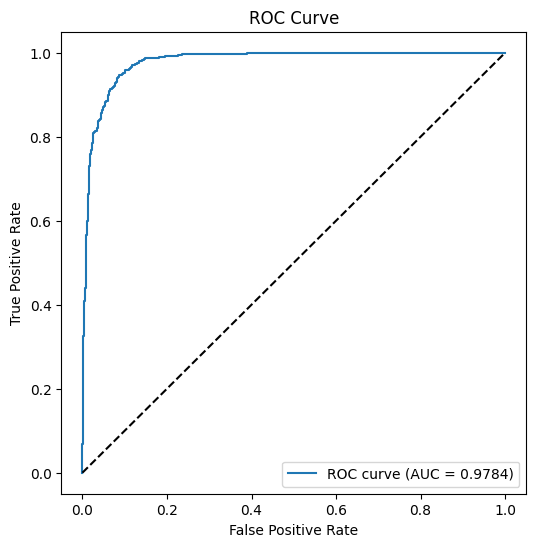

In [27]:
# Run evaluation on Random Forest Model
metrics = evaluate_binary_classification(boost, X_test_scaled_df, y_test)

In [ ]:
import joblib
import os

# Export folders
export_model_path = "../models" 
os.makedirs(export_model_path, exist_ok=True)
export_scaler_path = "../scalers" 
os.makedirs(export_scaler_path, exist_ok=True)

# Save model and scaler
joblib.dump(boost, os.path.join(export_model_path, "boostedTree.pkl"))

print("Model and scaler saved successfully!")